## Image Embedding Clustering with Feluda

This notebook demonstrates how to use the [`feluda`](https://github.com/tattle-made/feluda) to extract image embeddings, reduce their dimensions, and cluster them. It includes:
- Setting up Feluda and its operators.
- Using image data extracted from the [UCF101 video dataset](https://huggingface.co/datasets/sayakpaul/ucf101-subset) by extracting first frames from videos. We are using this for demo, but can be replaced with any image dataset.
- Generating image embeddings using feluda ResNet18 [image-vec-rep operator](https://pypi.org/project/feluda-image-vec-rep/).
- Reducing dimensions using Feluda's [dimension-reduction operator](https://pypi.org/project/feluda-dimension-reduction/).
- Using Feluda's [cluster-embeddings operator](https://pypi.org/project/feluda-cluster-embeddings/) to cluster images.
- Visualizing the clusters with image thumbnails.

In [ ]:
%%time
import sys

IN_COLAB = "google.colab" in sys.modules
print("Running Notebook in Google Colab" if IN_COLAB else "Running Notebook locally")

if IN_COLAB:
    # Since Google Colab has preinstalled libraries like tensorflow and numba, we create a folder called feluda_custom_venv and isolate the environment there.
    # This is done to avoid any conflicts with the preinstalled libraries.
    !pip install uv
    !mkdir -p /content/feluda_custom_venv
    !uv pip install --target=/content/feluda_custom_venv --prerelease allow feluda feluda-image-vec-rep feluda-dimension-reduction feluda-cluster-embeddings opencv-python matplotlib > /dev/null 2>&1

    sys.path.insert(0, "/content/feluda_custom_venv")
else:
    !uv pip install feluda feluda-image-vec-rep feluda-dimension-reduction feluda-cluster-embeddings opencv-python matplotlib > /dev/null 2>&1

In [1]:
import os
import tarfile
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from huggingface_hub import hf_hub_download
from tqdm.notebook import tqdm

from feluda.factory import ImageFactory

### We'll use three operators for this example:
1. ImageVecRep for extracting image embeddings using ResNet18
2. DimensionReduction for reducing high-dimensional embeddings to 2D
3. ClusterEmbeddings for clustering the reduced embeddings

In [13]:
from feluda.operators import ClusterEmbeddings, DimensionReduction, ImageVecRep

# Initialize operators
image_vec_operator = ImageVecRep()
dimension_reduction_operator = DimensionReduction("umap", {
    "n_components": 2,
    "n_neighbors": 15,
    "min_dist": 0.1,
    "random_state": 42
})
cluster_operator = ClusterEmbeddings()

UMAP model successfully initialized


## Data Preparation

In [ ]:
dataset_name = "UCF101_subset/train"
hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"

print("Downloading and extracting dataset...")
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)

with tarfile.open(file_path) as t:
    t.extractall(".")
print(f"Dataset extracted to {dataset_name}")


Dataset extracted to UCF101_subset/train


/var/folders/4p/bw6h5x8x1nb_17vsgfc12dz00000gn/T/ipykernel_7812/653585941.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall(".")


In [4]:
# Create thumbnails directory for extracted images
thumbnail_dir = Path("image_thumbnails")
thumbnail_dir.mkdir(exist_ok=True)

In [5]:
def extract_image_from_video(video_path: str, save_path: str) -> str | None:
    """Extract and save the first frame from the video as an image.

    Args:
        video_path: Path to the video file
        save_path: Directory to save the extracted image

    Returns:
        Path to the saved image or None if extraction failed
    """
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()  # Read the first frame

    if ret:
        image_filename = os.path.basename(video_path).replace(".avi", "_frame.jpg")
        image_path = os.path.join(save_path, image_filename)
        cv2.imwrite(image_path, frame)  # Save the frame as a JPEG
        cap.release()
        return image_path  # Return the path to the saved image

    cap.release()
    return None

Processing videos and extracting image embeddings

In [ ]:

operator_parameters = []
sub_folder_name = os.listdir(f"{dataset_name}")

for class_dir in tqdm(sub_folder_name, desc="Processing classes"):
    temp_list = os.listdir(os.path.join(dataset_name, class_dir))

    # Process up to 8 images per class
    image_count = 0
    for video_file in temp_list:
        if video_file == "UCF101" or image_count >= 8:
            continue

        video_full_path = os.path.join(dataset_name, class_dir, video_file)

        try:

            image_path = extract_image_from_video(video_full_path, thumbnail_dir)
            
            if image_path is None:
                continue

   
            image_obj = ImageFactory.make_from_file_on_disk(image_path)
            
            # Extract image embedding using ResNet18
            embedding = image_vec_operator.run(image_obj)

            operator_parameters.append(
                {
                    "payload": image_path,
                    "embedding": embedding.tolist(), 
                    "class": class_dir,  
                }
            )

            image_count += 1
        except Exception as e:
            print(f"Error processing {video_full_path}: {e}")
            continue

print(f"Successfully processed {len(operator_parameters)} images")

Processing classes:   0%|          | 0/10 [00:00<?, ?it/s]

Successfully processed 80 images


Reduce the 512-dimensional ResNet18 embeddings to 2D for visualization


In [7]:
reduced_embeddings = dimension_reduction_operator.run(operator_parameters)

/Users/omkarkabde/Desktop/feluda/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/omkarkabde/Desktop/feluda/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/omkarkabde/Desktop/feluda/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/omkarkabde/Desktop/feluda/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/omkarkabde/Desktop/feluda/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/omkarkabde/Desktop/feluda/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: inval

In [ ]:
# Prepare data for clustering (using the reduced embeddings)
clustering_data = []
for i, item in enumerate(reduced_embeddings):
    clustering_data.append({
        "payload": item["payload"],
        "embedding": item["reduced_embedding"],
        "class": operator_parameters[i]["class"]
    })

print("Clustering image embeddings...")
n_clusters = 15  # Number of clusters to create
clusters = cluster_operator.run(
    clustering_data, n_clusters=n_clusters, modality="audio"  # Using audio modality for kmeans clustering
)

# Sort clusters by label for consistent display
clusters = {key: clusters[key] for key in sorted(clusters)}

Clustering image embeddings...


In [9]:
def load_image(image_path):
    """Load an image from the specified path.

    Args:
        image_path: Path to the image file

    Returns:
        Loaded image or None if not found
    """
    if os.path.exists(image_path):
        return cv2.imread(image_path)
    print(f"Image not found: {image_path}")
    return None


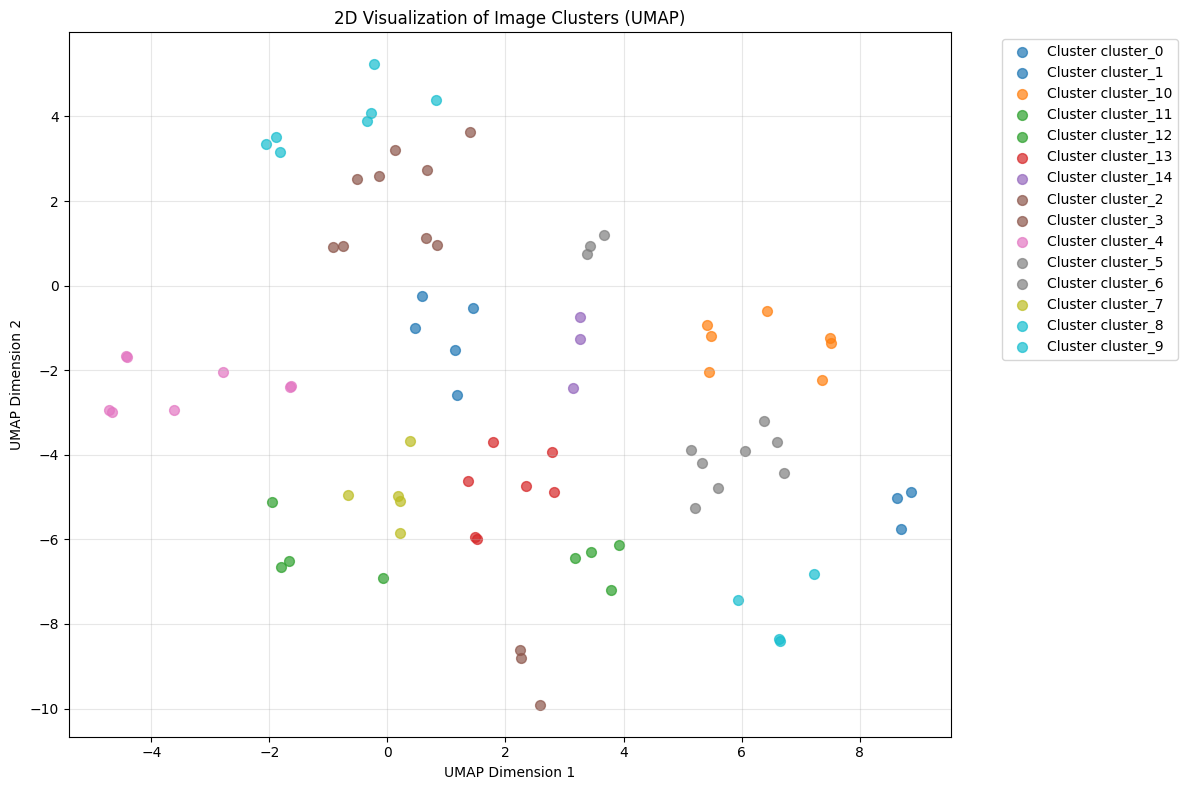

In [25]:
# Create scatter plot of reduced embeddings
plt.figure(figsize=(12, 8))

# Prepare data for scatter plot
cluster_colors = plt.cm.tab10(np.linspace(0, 1, len(clusters)))
cluster_labels = list(clusters.keys())

for i, (cluster_label, image_paths) in enumerate(clusters.items()):
    if not image_paths:
        continue
    
    # Get reduced embeddings for this cluster
    cluster_embeddings = []
    cluster_classes = []
    
    for image_path in image_paths:
        # Find the corresponding reduced embedding
        for item in reduced_embeddings:
            if item["payload"] == image_path:
                cluster_embeddings.append(item["reduced_embedding"])
                # Find the class name
                for orig_item in operator_parameters:
                    if orig_item["payload"] == image_path:
                        cluster_classes.append(orig_item["class"])
                        break
                break
    
    if cluster_embeddings:
        cluster_embeddings = np.array(cluster_embeddings)
        plt.scatter(cluster_embeddings[:, 0], cluster_embeddings[:, 1], 
                   c=[cluster_colors[i]], label=f"Cluster {cluster_label}", 
                   alpha=0.7, s=50)

plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("2D Visualization of Image Clusters (UMAP)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Cluster Analysis:

Cluster cluster_0 (5 images):
  - BabyCrawling: 5 images


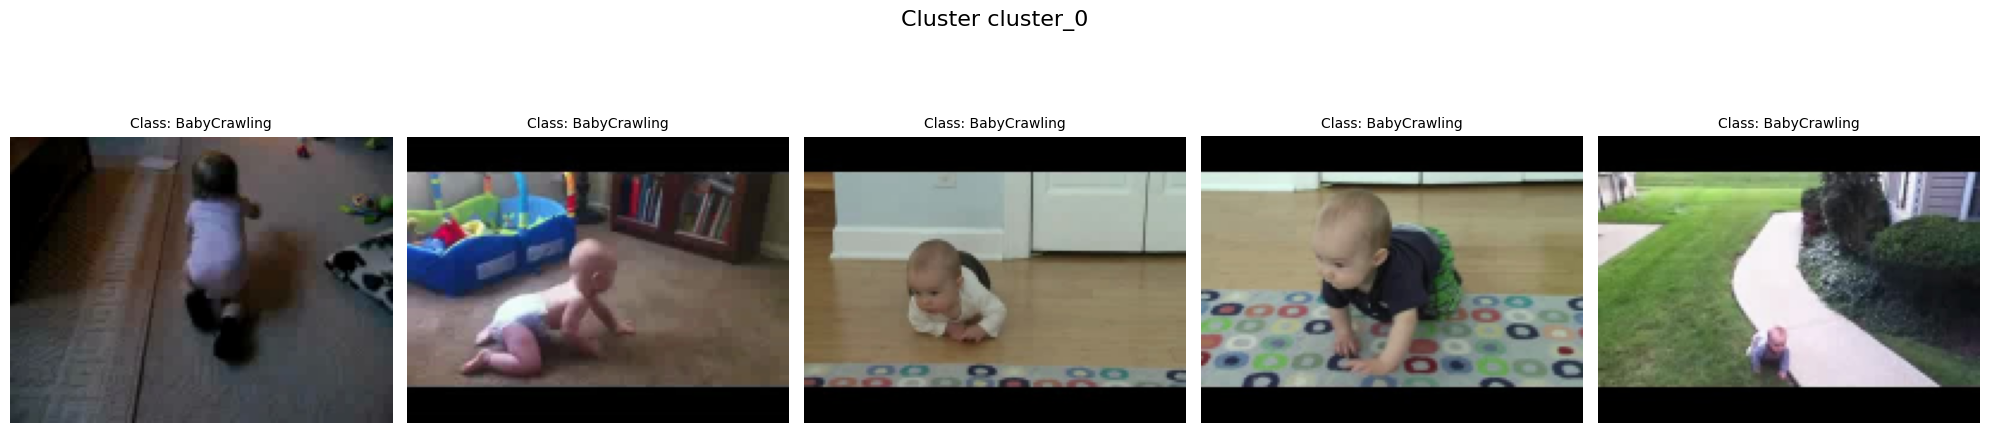


Cluster cluster_1 (3 images):
  - BaseballPitch: 3 images


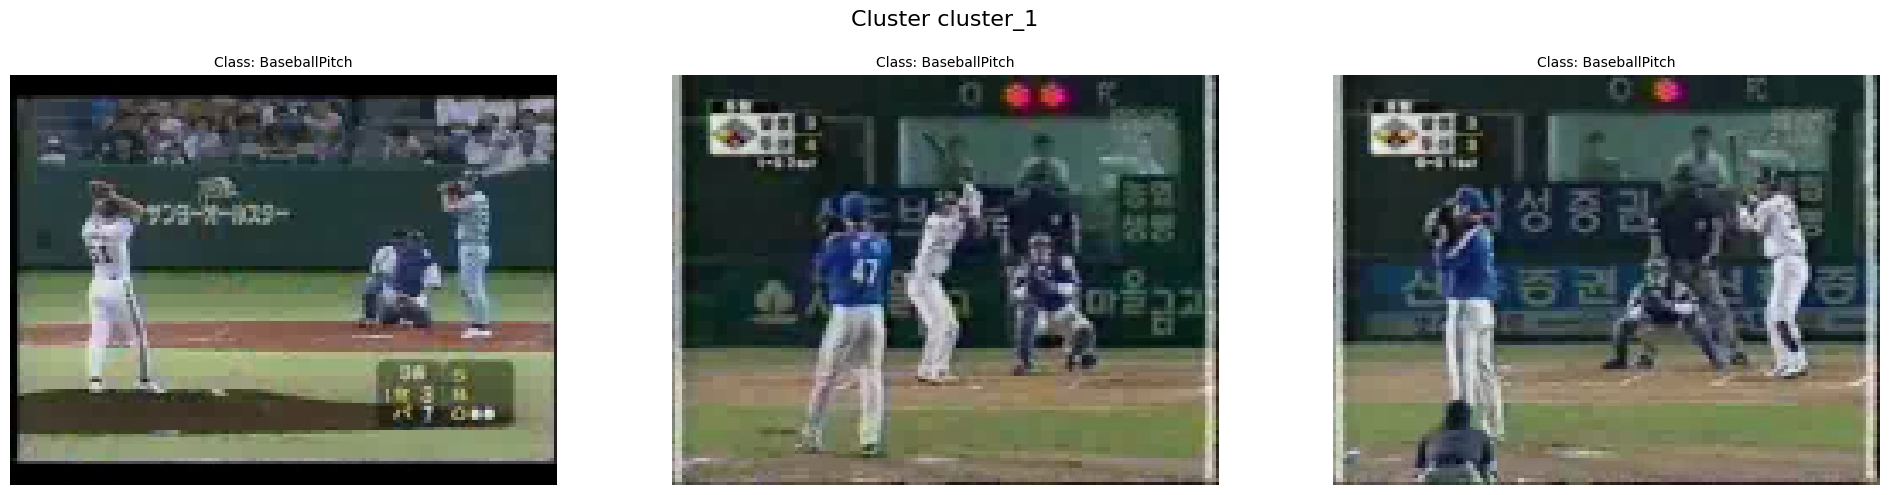


Cluster cluster_10 (7 images):
  - BalanceBeam: 7 images


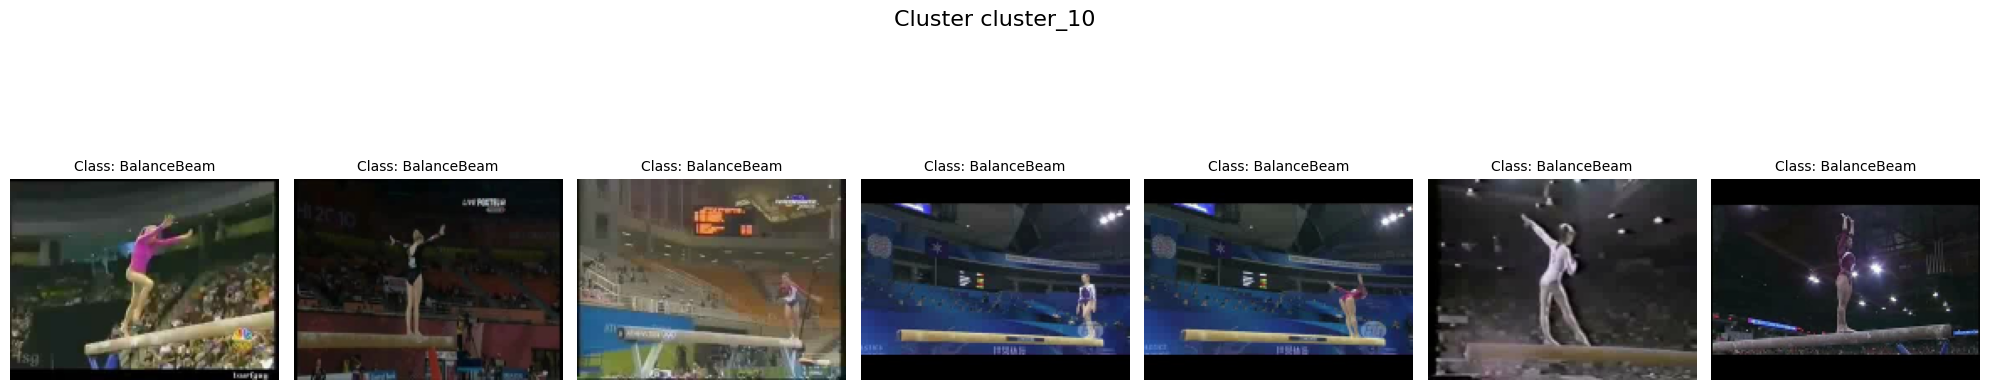


Cluster cluster_11 (4 images):
  - BandMarching: 4 images


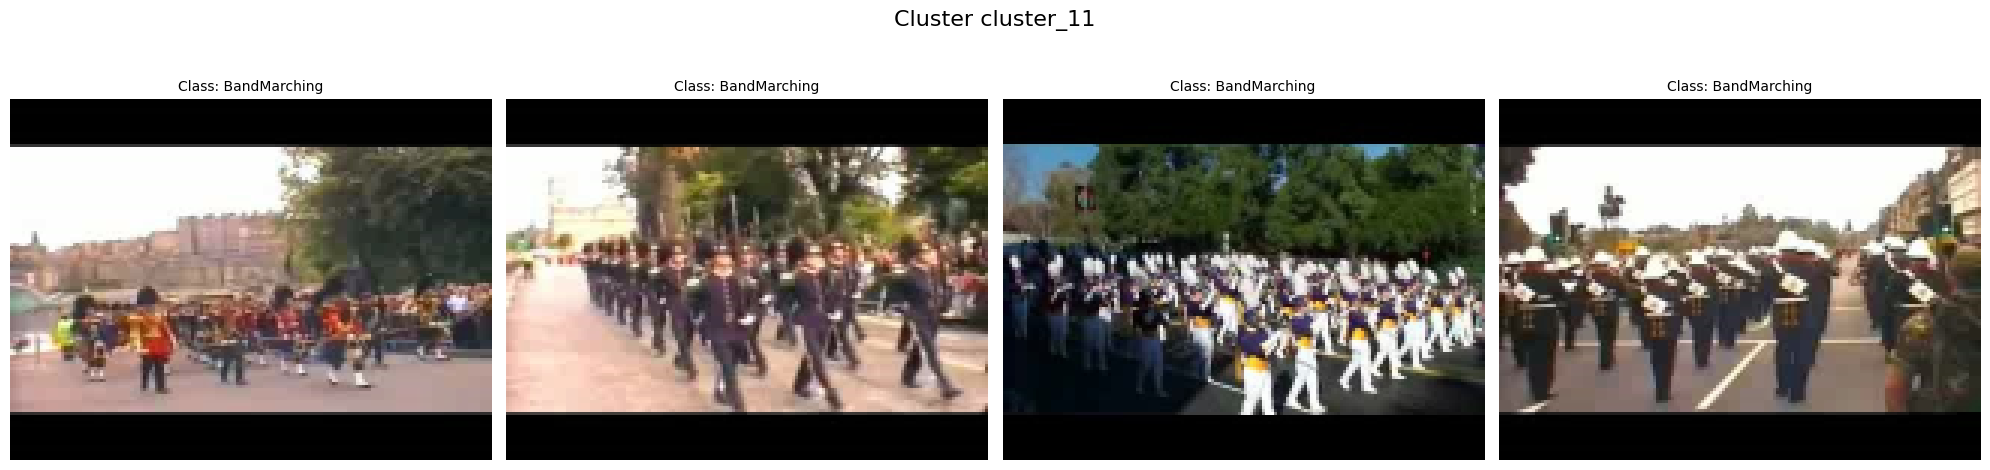


Cluster cluster_12 (4 images):
  - Archery: 4 images


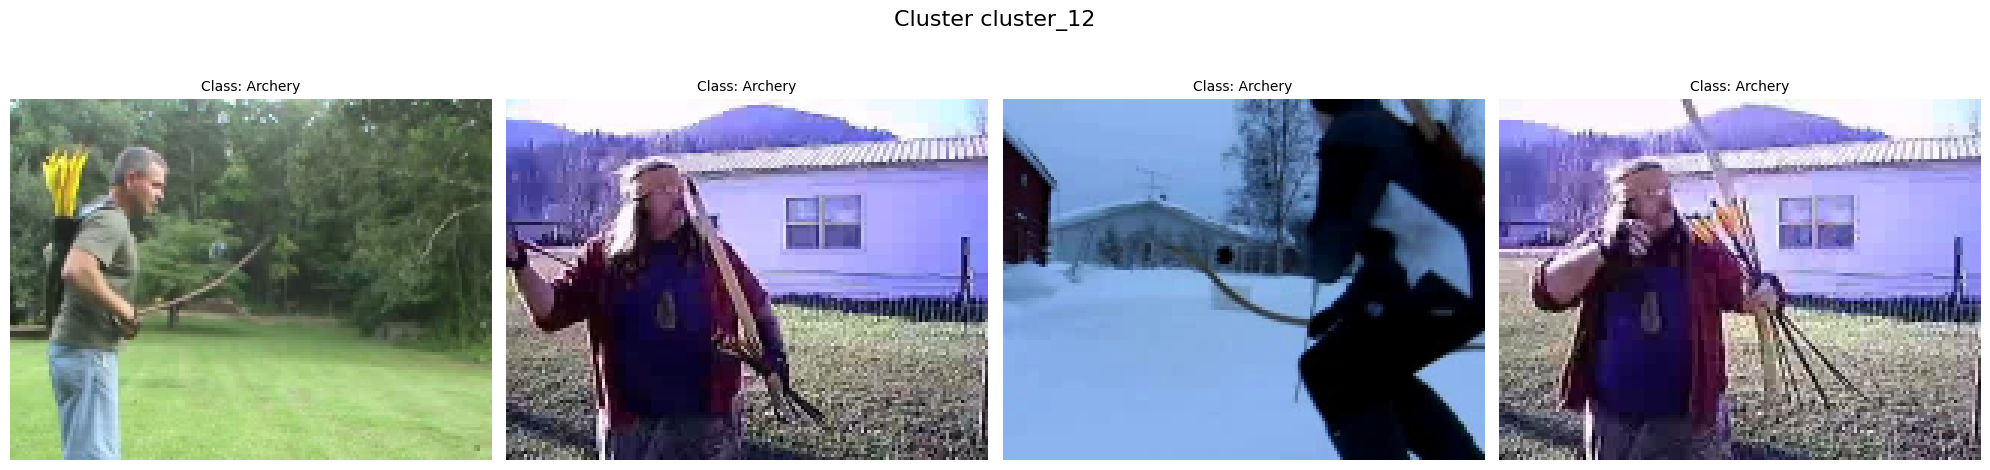


Cluster cluster_13 (7 images):
  - Archery: 3 images
  - BandMarching: 1 images
  - Basketball: 3 images


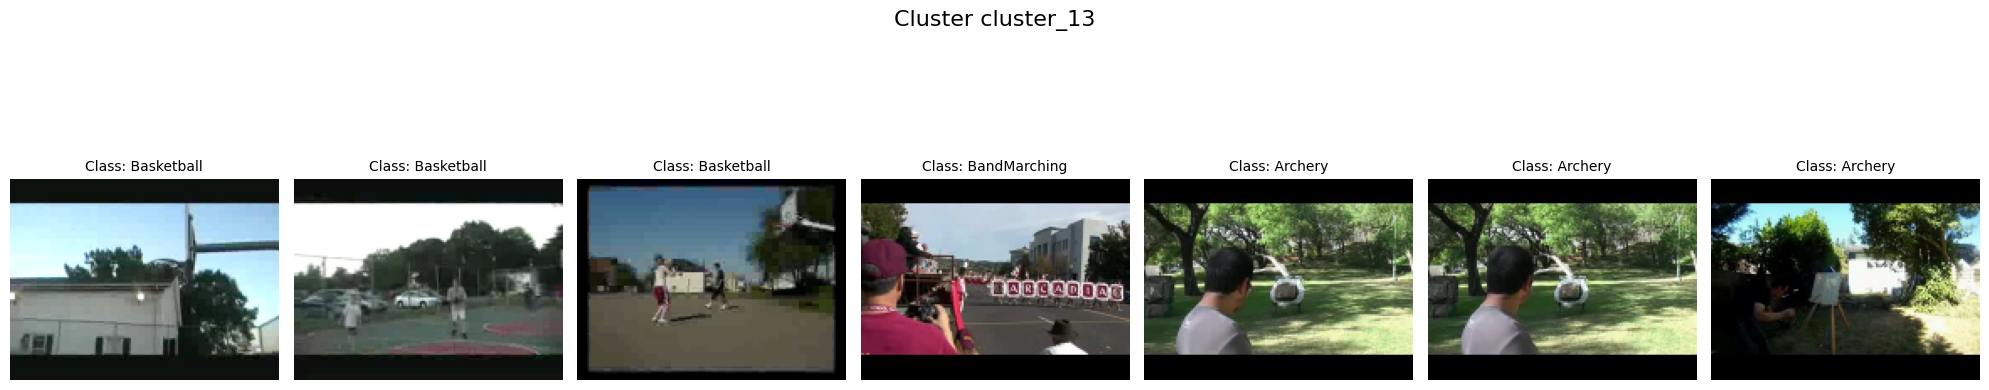


Cluster cluster_14 (3 images):
  - BalanceBeam: 1 images
  - Basketball: 2 images


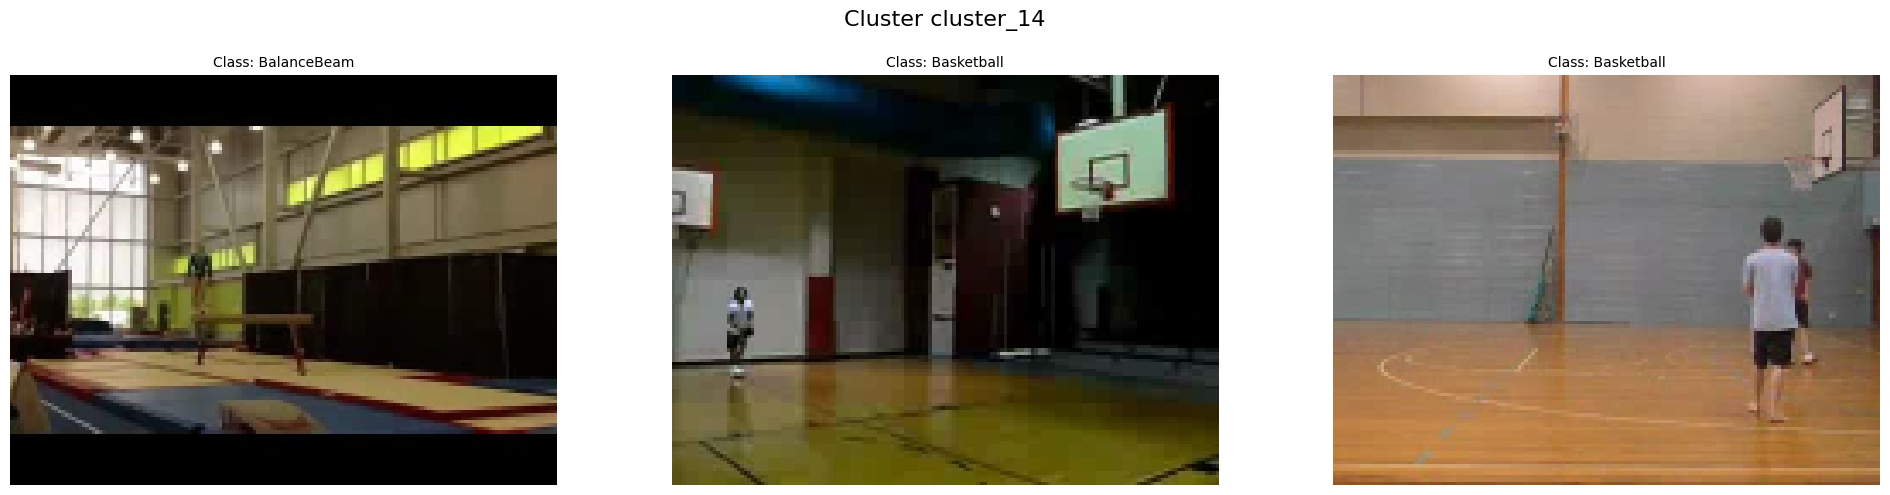


Cluster cluster_2 (9 images):
  - ApplyEyeMakeup: 5 images
  - ApplyLipstick: 4 images


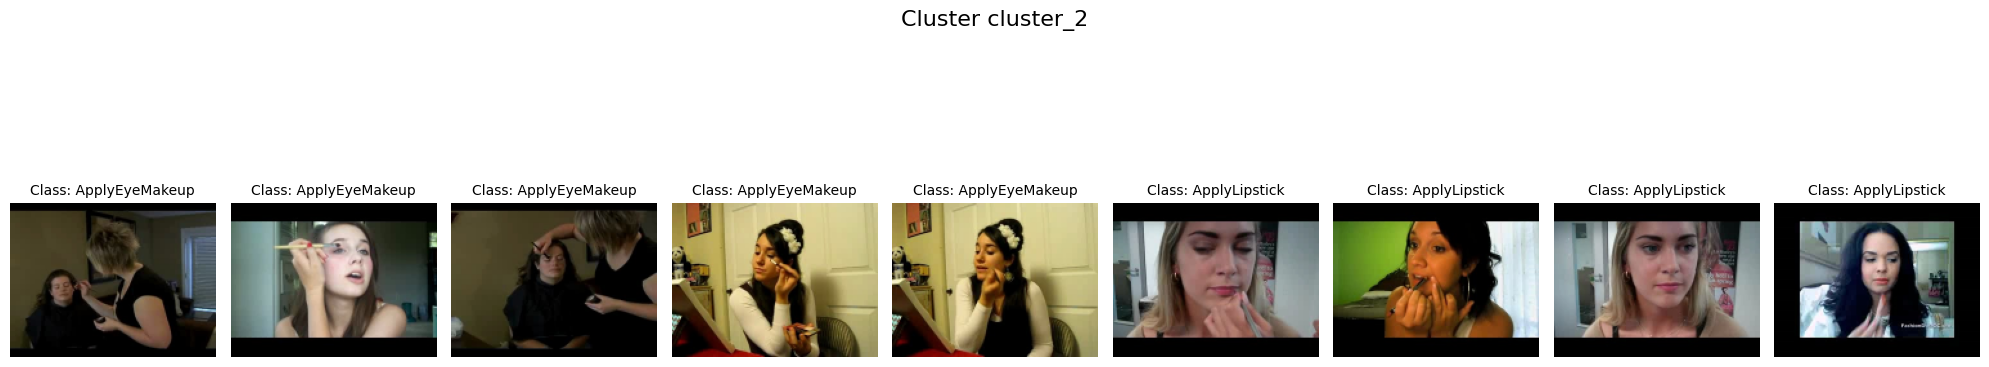


Cluster cluster_3 (3 images):
  - BandMarching: 3 images


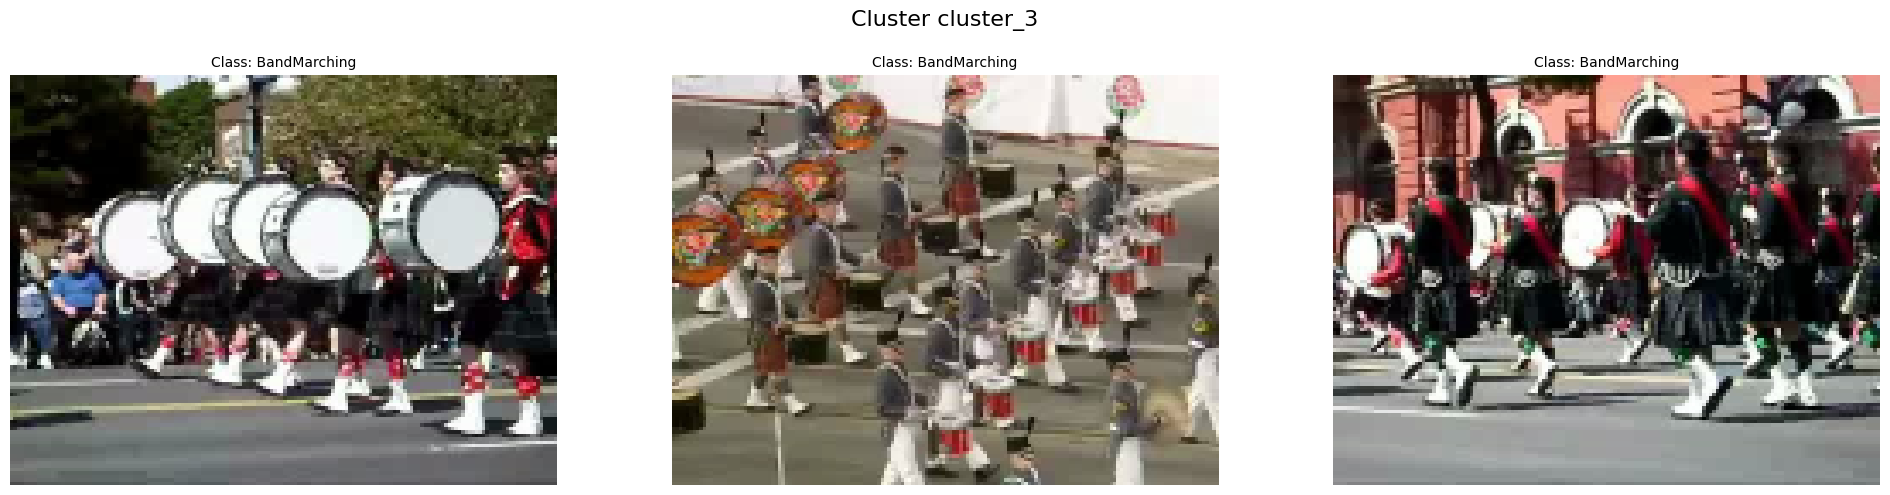


Cluster cluster_4 (8 images):
  - BenchPress: 8 images


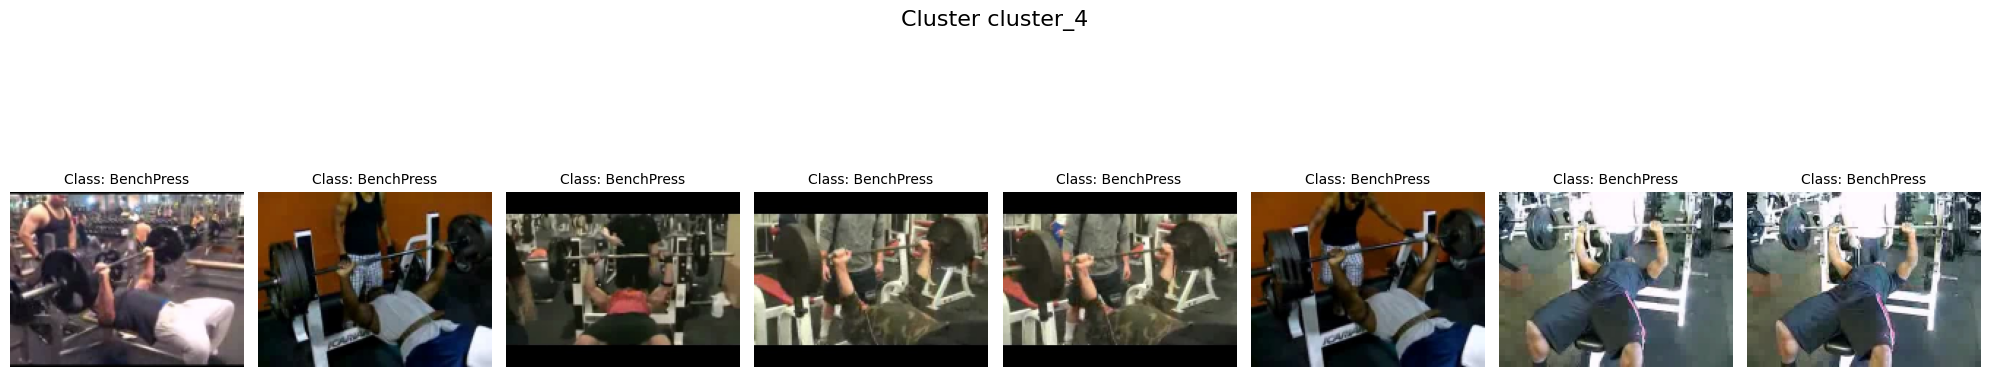


Cluster cluster_5 (8 images):
  - BasketballDunk: 8 images


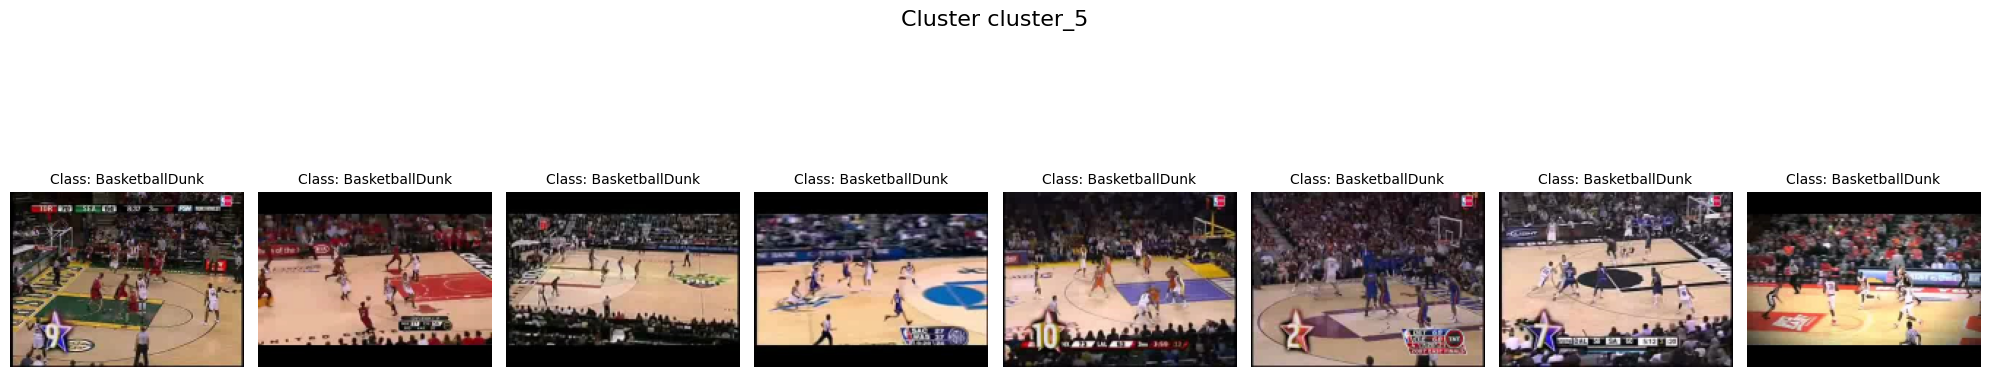


Cluster cluster_6 (3 images):
  - BabyCrawling: 3 images


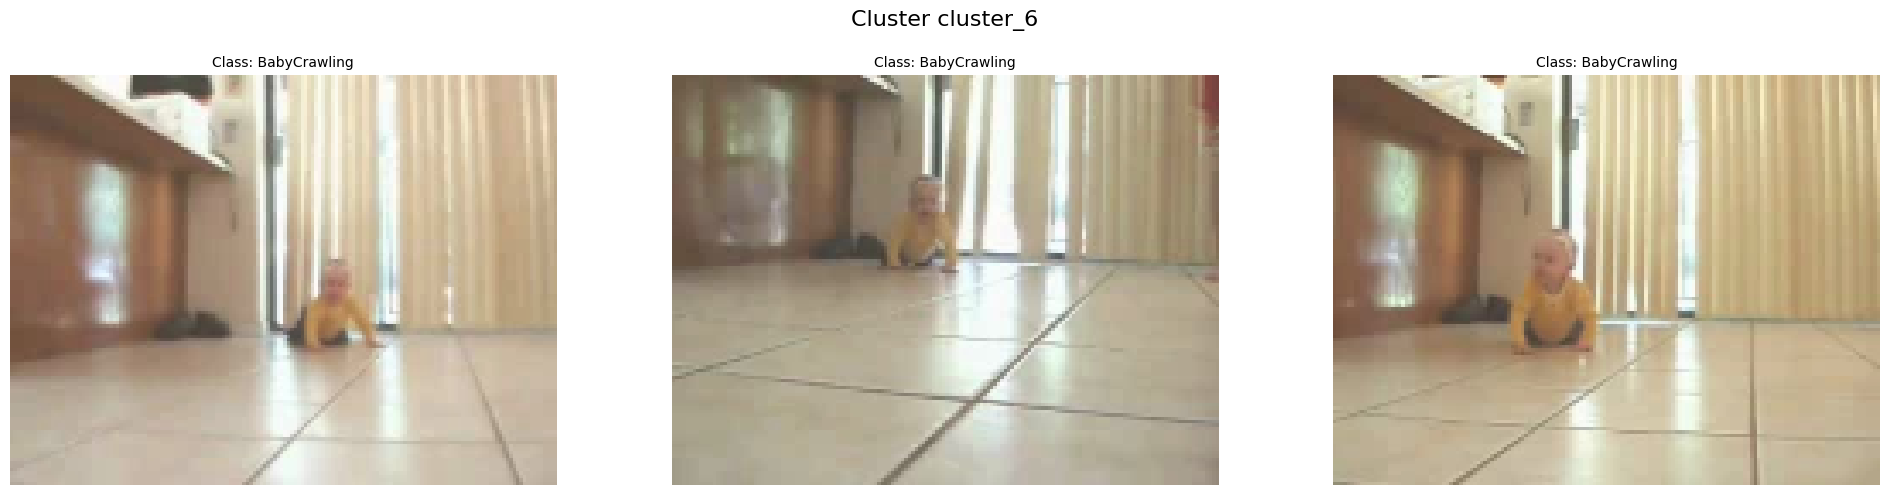


Cluster cluster_7 (5 images):
  - Archery: 1 images
  - BaseballPitch: 1 images
  - Basketball: 3 images


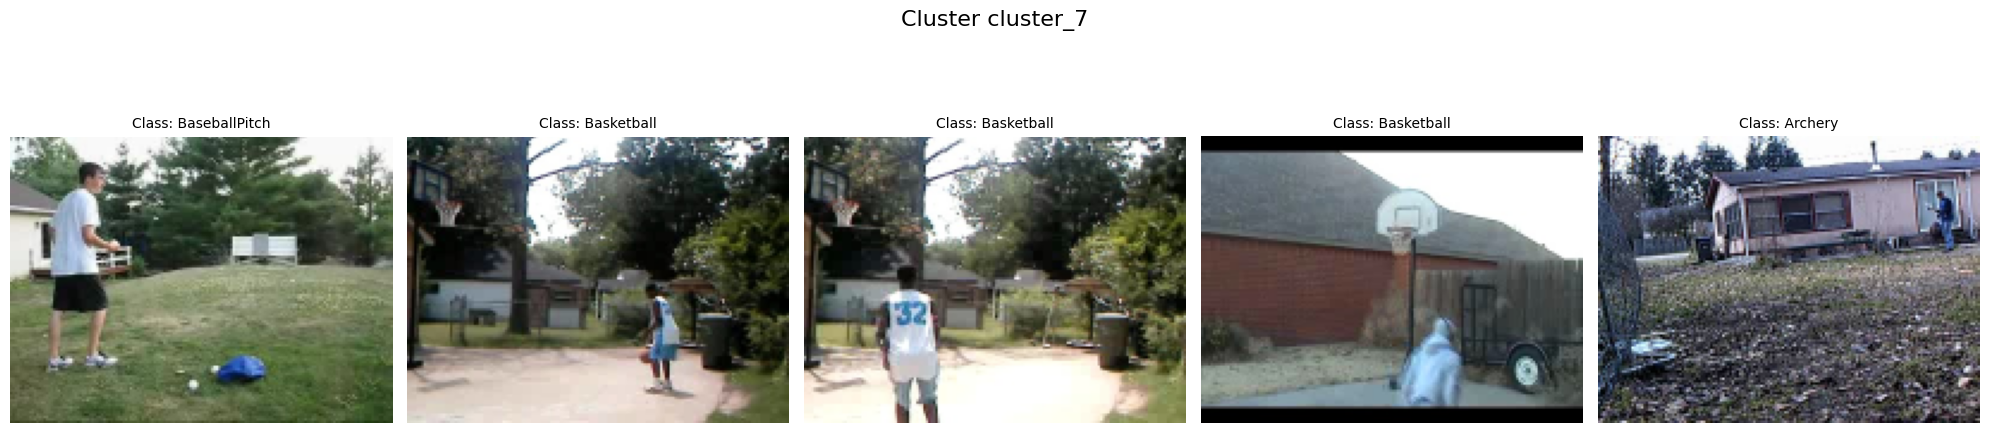


Cluster cluster_8 (7 images):
  - ApplyEyeMakeup: 3 images
  - ApplyLipstick: 4 images


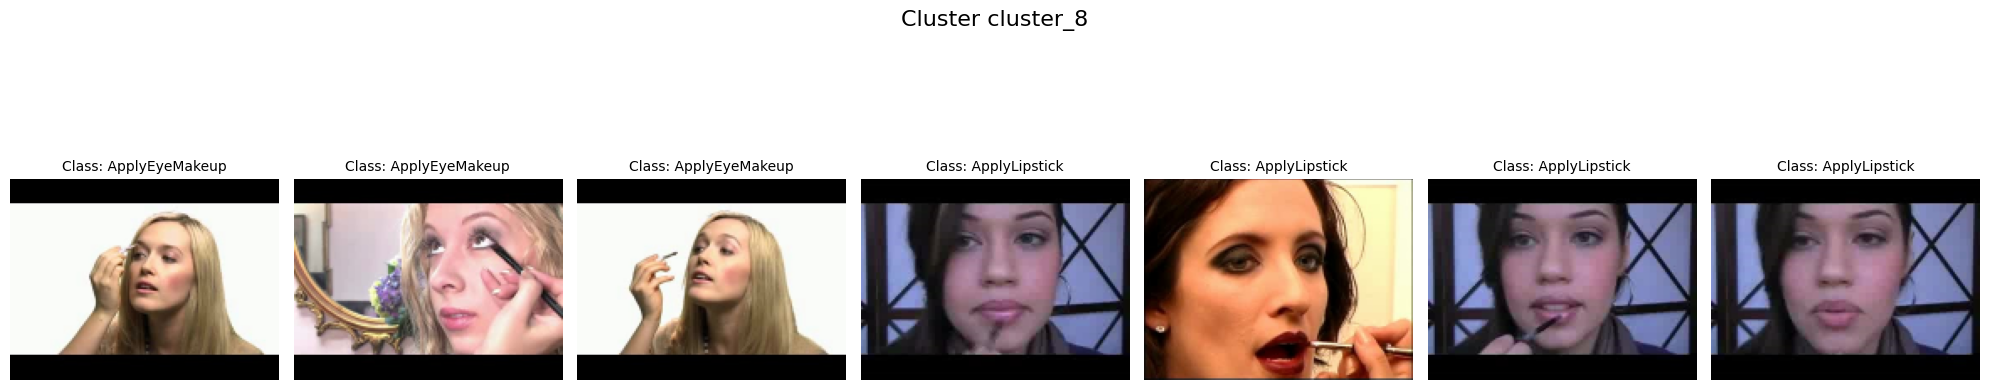


Cluster cluster_9 (4 images):
  - BaseballPitch: 4 images


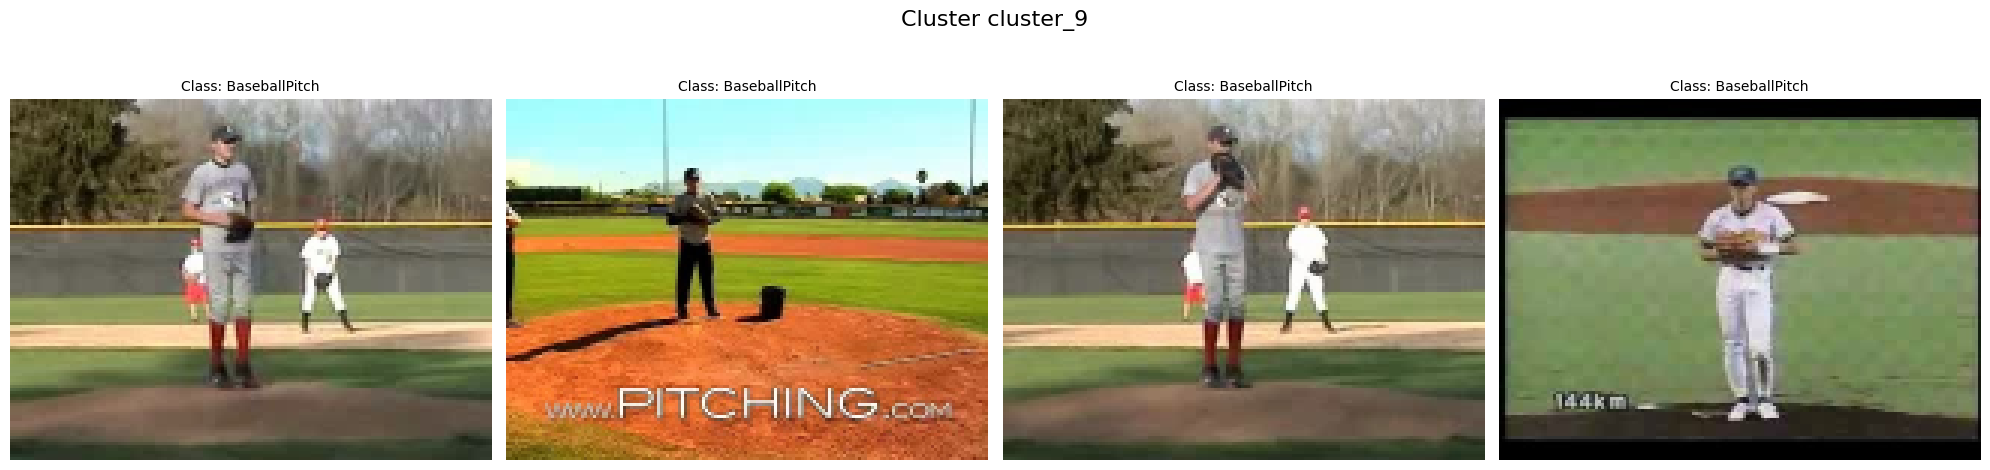

In [24]:
print("Cluster Analysis:")
print("=" * 50)

for cluster_label, image_paths in clusters.items():
    num_images = len(image_paths)
    print(f"\nCluster {cluster_label} ({num_images} images):")

    # Create a subplot for each image in the cluster
    fig, axes = plt.subplots(1, max(1, num_images), figsize=(20, 5))
    # Handle case where there's only one image in a cluster
    if num_images == 1:
        axes = [axes]
    
    # Count classes in this cluster
    class_counts = {}
    for i, image_path in enumerate(image_paths):
        for item in operator_parameters:
            if item["payload"] == image_path:
                class_name = item["class"]
                image = load_image(image_path)
                if image is not None:
                    # Resize and convert color format
                    image = cv2.cvtColor(
                        cv2.resize(image, (160, 120)), cv2.COLOR_BGR2RGB
                    )
                    axes[i].imshow(image)
                    axes[i].set_title(f"Class: {class_name}", fontsize=10)
                    axes[i].axis("off")

                class_counts[class_name] = class_counts.get(class_name, 0) + 1
                break
    
    # Display class distribution
    for class_name, count in sorted(class_counts.items()):
        print(f"  - {class_name}: {count} images")

    plt.suptitle(f"Cluster {cluster_label}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


Clean up dataset and operators

In [26]:
import shutil

# Remove thumbnail directory
if os.path.exists(thumbnail_dir):
    shutil.rmtree(thumbnail_dir)
    print(f"Removed {thumbnail_dir}")

# Remove dataset directory
if os.path.exists("UCF101_subset"):
    shutil.rmtree("UCF101_subset")
    print("Removed UCF101_subset")

# Remove downloaded dataset file
if os.path.exists(file_path):
    os.remove(file_path)
    print("Removed dataset")

# Cleanup operators
image_vec_operator.cleanup()
dimension_reduction_operator.cleanup()
cluster_operator.cleanup()

Removed image_thumbnails
Removed UCF101_subset
Removed dataset
